In [1]:
%config Completer.use_jedi = False

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

import os
import copy
from copy import deepcopy
from shapely.geometry import Point, Polygon
from jmetal.util.constraint_handling import overall_constraint_violation_degree
from scipy.spatial.distance import squareform 
from scipy.spatial.distance import pdist
from jmetal.util.observer import ProgressBarObserver
from jmetal.util.constraint_handling import *
from Problem.JMetalPy_modified import *
from Problem.ConstraintEvaluation import *
from Problem.PerformanceObserver import *
from Problem.InitialSolution import *
from Problem.FitnessEvaluation import *
from Problem.PlotFunctions import *
from Problem.RoutingContext import *
from Problem.VehicleFunctions import *
from Problem.VRP import *
from Problem.VRPtest import *
from Problem.utils import *
#import geoplot as gplt
#import geopandas as gpd
# https://stackoverflow.com/questions/40536560/ipython-and-jupyter-autocomplete-not-working#40544668
api = "Tfmt6Sxyn-nfinSHUyUo3xmVDWdtwAUyh6C8Y3HTZhU"

# 25_2, 25_4, 25_8, 50_1, 50_2, 50_4, 75_1, 75_3, 75_6
dataset = "UK75_6"
meta_data, distance_data, station_data = parse_UK_Data("../datasets/{}/{}.txt".format(dataset[:-2],dataset))

station_coordinates = pd.read_csv('../datasets/{}/{}_coordinates.csv'.format(dataset[:-2],dataset), encoding='utf-8')
points_coordinate = station_coordinates[["lat", "lng"]].to_numpy()
#dbf = gpd.GeoDataFrame.from_file(u"../datasets/united_kingdom_european_regions/european_region_region.dbf")
#dbf = dbf.to_crs("EPSG:4326")
meta_data["F-C Empty (l/100km)"] = 12.5
meta_data["F-C Full (l/100km)"] = 15
meta_data["Vehicle Weight"] = 3000

distance_matrix_here,time_matrix_here = load_saved_here_data("../datasets/{}/".format(dataset[:-2]),dataset)

distance_matrix_here = distance_matrix_here.to_numpy()
time_matrix_here = time_matrix_here.to_numpy()

routingContext = RoutingContext(distance_matrix=distance_matrix_here,time_matrix=time_matrix_here,station_coordinates=station_coordinates,station_data=station_data,meta_data=meta_data)
startNodes = {"UK20_1":[0,6,10,15],"UK25":[0,6,10,15],"UK50":[0,6,10,15,21,35,40],"UK75":[0,6,10,15,21,35,40,60,31,68]}
endNodes = {"UK20_1":[4,20,2,5],"UK25":[4,20,2,5,22],"UK50":[4,20,2,5,32,45,1],"UK75":[4,20,2,5,32,45,1]}

evaluation_amount = {"UK25":3000,"UK50":5000,"UK75":10000}

In [2]:
startNodeIndeces = startNodes[dataset[:-2]]
endNodeIndeces = endNodes[dataset[:-2]]
locationNodeIndeces = list((set(range(len(points_coordinate))) - set(startNodeIndeces)) - set(endNodeIndeces))

vehicleData = {"emptyWeights":[3000,5500],"maxLoads":[3650,8500],"fuelEmpty":[12,22.5],"fuelFull":[15,27.5]}


vehicles = initializeVehicles(startIndices=startNodeIndeces,vehicleData=vehicleData,heterogeneousFleet=True)




customer_demands = station_data.T.loc["Demand(kg)"].astype(int).to_numpy()
customer_demands[startNodeIndeces+endNodeIndeces] = 0
station_data["Demand(kg)"] = customer_demands

translate_dict = {}
for i,x in enumerate(endNodeIndeces):
    translate_dict[x] = 100+i
initial_solution = cheapest_insertion_dict(locationNodeIndeces,vehicles,endNodeIndeces,routingContext)


cost_function_dict = {"distance_matrix":distance_matrix_here,"time_matrix":time_matrix_here,
                              "demands":customer_demands,"vehicle_weight":3000,"start_positions":startNodeIndeces,"meta_data":meta_data}


min_allowed_drivetime_hours = 0

data_model_input_single_objective = {'routing_context':routingContext,'vehicles':vehicles,'end_points':endNodeIndeces,'pickup_points':locationNodeIndeces,
                                    'initial_solution':initial_solution,
                                    'objective_amount':1,'objective_labels':['Total Fuel'],
                                    'constraint_amount':6,'number_of_cities':routingContext.distance_matrix.shape[0],
                                    'min_drivetime':min_allowed_drivetime_hours}


data_model_input_multi_objective = {'routing_context':routingContext,'vehicles':vehicles,'end_points':endNodeIndeces,'pickup_points':locationNodeIndeces,
                                    'initial_solution':initial_solution,
                                    'objective_amount':2,'objective_labels':['Total Fuel','Total Drive Time'],
                                    'constraint_amount':6,'number_of_cities':routingContext.distance_matrix.shape[0],
                                    'min_drivetime':min_allowed_drivetime_hours}


plot_data_storage_base = {'fitness':[], 'route_distance':[],'fuel_consumption':[],'vehicle_loads':[],'computation_times':[],'vehicle_route_time':[],'violation':[],'paths':[],'distance_to_origin':[]}


amount_of_runs = 30
amount_of_evaluations = evaluation_amount[dataset[:-2]]
observer_update_interval = 60
logpath = "parameter_data/pick_and_drop_results/{}".format(dataset)
try: 
    os.mkdir(logpath) 
except OSError as error: 
    print(error) 

mutation_arange = np.arange(0.1,1,0.2)
crossover_arange = np.arange(0.25,0.8,0.25)
population_size_arange = np.arange(10,40,10)


genetic_algorithms_parameters = []

for x in mutation_arange:
    for y in crossover_arange:
        for z in population_size_arange:
            genetic_algorithms_parameters.append({"mutation":np.round(x,2),"crossover":np.round(y,2),"population_size":np.round(z,2)})

            
optimal_parameters = {"SA":{"mutation":0.9}, "GA":{"mutation":0.9,"crossover":0.25,"population_size":30},
                     "NSGAII":{"mutation":0.9,"crossover":0.50,"population_size":30},
                     "NSGAIII":{"mutation":0.9,"crossover":0.50,"population_size":20},
                     "UNSGAIII":{"mutation":0.9,"crossover":0.25,"population_size":20},
                     "IBEA":{"mutation":0.9,"crossover":0.75,"population_size":20}}
parameters_NSGAIII = optimal_parameters["NSGAIII"]
       

[Errno 17] File exists: 'parameter_data/pick_and_drop_results/UK75_6'


In [3]:
def plot_vehicle_drivetimes(dataframe,parameter_group):
    plt.style.use("../src/style/custom-seaborn-2dplot.mplstyle")
    fig, ax = plt.subplots(1,1)
    
    dataframe_parameter_group = dataframe.where(dataframe["Parameter Group"] == parameter_group).dropna()
    
    if type(dataframe_parameter_group.vehicle_route_time.iloc[0]) == str:
        dataframe_parameter_group.vehicle_route_time = dataframe_parameter_group.vehicle_route_time.apply(literal_eval)
        
    dataframe_parameter_group["vehicle_amount"] = dataframe_parameter_group.vehicle_route_time.apply(lambda x: len(x))
    
    vehicle_amounts = sorted(dataframe_parameter_group.vehicle_amount.unique())
    num_bars = len(vehicle_amounts)
    offsets = np.linspace(-num_bars/12, num_bars/12, num_bars)
    
    for vehicle_amount,offset in zip(vehicle_amounts,offsets):
        vehicle_amount_df = dataframe_parameter_group.where(dataframe_parameter_group.vehicle_amount == vehicle_amount).dropna()
        
        vehicle_amount_route_times = np.stack(vehicle_amount_df.vehicle_route_time.apply(lambda x: np.sort(x)[::-1]/60).to_numpy())
        vehicle_route_times_mean = np.mean(vehicle_amount_route_times,axis=0)
        plt.bar(np.arange(vehicle_amount) + offset,vehicle_route_times_mean,width=0.2,alpha=0.5,label=r"$\bf{%s}\ Vehicles$" % (vehicle_amount))
    
    plt.ylabel("Drivetime (minutes)")
    plt.xlabel("Vehicles")
    
    plt.legend(bbox_to_anchor=(1,1))
        
    
    

# With Pick and Drop

In [35]:
from jmetal.algorithm.multiobjective.nsgaiii import NSGAIII, UniformReferenceDirectionFactory,ReferenceDirectionFactory
from jmetal.operator.crossover import PMXCrossover, CXCrossover
from jmetal.operator.mutation import PermutationSwapMutation,ScrambleMutation
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.util.evaluator import MultiprocessEvaluator
from jmetal.util.solution import get_non_dominated_solutions
from jmetal.util.observer import ProgressBarObserver
from jmetal.util.density_estimator import CrowdingDistance
from jmetal.util.ranking import FastNonDominatedRanking
from jmetal.util.comparator import DominanceComparator, Comparator, MultiComparator



plot_data_NSGAIII_pick_and_drop = deepcopy(plot_data_storage_base)
data_model_input_multi_objective["objective_amount"] = 3
for x in range(10):

    problem_NSGAIII_pick_and_drop = VRP_pickup_and_drop(data_model_input_multi_objective)
    problem_NSGAIII_pick_and_drop.name = "NSGA-III"
    problem_NSGAIII_pick_and_drop.assignClosestEndPoint = True
    max_evaluations = amount_of_evaluations

    algorithm_NSGAIII_pick_and_drop = NSGAIII(problem=problem_NSGAIII_pick_and_drop,
                            population_size=parameters_NSGAIII["population_size"],
                            reference_directions=UniformReferenceDirectionFactory(3, n_points=8),
                            mutation= PermutationSwapMutation(parameters_NSGAIII["mutation"]),
                            crossover=PMXCrossover(parameters_NSGAIII["crossover"]),
                            termination_criterion=StoppingByEvaluations(max_evaluations)
                            ,population_evaluator=MultiprocessEvaluator()
                               )
    performance_observer_NSGAIII_pick_and_drop = PerformanceObserver(max_iter=max_evaluations,frequency=observer_update_interval,params=[parameters_NSGAIII])
    performance_observer_NSGAIII_pick_and_drop.maxEpochs=  amount_of_runs
    performance_observer_NSGAIII_pick_and_drop.currentEpoch =  x

    algorithm_NSGAIII_pick_and_drop.observable.register(observer=performance_observer_NSGAIII_pick_and_drop)
    algorithm_NSGAIII_pick_and_drop.run()

    solutions_NSGAIII_pick_and_drop = algorithm_NSGAIII_pick_and_drop.get_result()
    front_NSGAIII_pick_and_drop = get_non_dominated_solutions(solutions_NSGAIII_pick_and_drop)
    best_sol = sorted(front_NSGAIII_pick_and_drop,key=lambda solution:np.sum(solution.objectives))[0]
    store_plot_data(plot_data_NSGAIII_pick_and_drop,performance_observer_NSGAIII_pick_and_drop,best_sol)

Epoch:10 of 30
Evaluations: 480/5000
Params: {'mutation': 0.9, 'crossover': 0.5, 'population_size': 20}
Best fitness: 183.5097 --- 24.8781 --- 36.8851                        
Best total fuel consumption:183.51 
Computing time: 0.47s                        
Average computing speed: 1016.07it/s
Current Route:[['V3', 39, 8, 32], ['V2', 22, 33, 25, 47, 9, 32], ['V4', 12, 28, 20], ['V5', 36, 41, 42, 20], ['V6', 46, 27, 44, 43, 30, 31, 5], ['V7', 16, 3, 37, 11, 13, 1], ['V10', 48, 24, 14, 38, 50, 34, 19, 20], ['V12', 29, 32], ['V13', 23, 17, 26, 18, 49, 7, 1]]
Flags: []                        
Violation:0
Vehicle amount:9


Process ForkPoolWorker-1552:
Process ForkPoolWorker-1560:
Process ForkPoolWorker-1557:
Process ForkPoolWorker-1553:
Process ForkPoolWorker-1555:
Process ForkPoolWorker-1559:
Process ForkPoolWorker-1558:
Process ForkPoolWorker-1554:
Process ForkPoolWorker-1556:
Process ForkPoolWorker-1550:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.9/multiprocessing/process

KeyboardInterrupt: 

In [118]:
pd.DataFrame(plot_data_NSGAIII_pick_and_drop).to_csv("{}/NSGAIII_pick_and_drop.csv".format(logpath))

In [4]:
from jmetal.algorithm.multiobjective.ibea import IBEA
from jmetal.operator.crossover import PMXCrossover,CXCrossover
from jmetal.operator.mutation import PermutationSwapMutation, ScrambleMutation
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.util.evaluator import MultiprocessEvaluator
from jmetal.operator import SBXCrossover, RandomSolutionSelection,BestSolutionSelection,RankingAndCrowdingDistanceSelection
from jmetal.operator.selection import   RouletteWheelSelection
from jmetal.util.solution import get_non_dominated_solutions
from datetime import datetime

parameters_IBEA = optimal_parameters["IBEA"]

plot_data_IBEA = deepcopy(plot_data_storage_base)
data_model_input_multi_objective["objective_amount"] = 3
for x in range(amount_of_runs):
    problem_IBEA = VRP_pickup_and_drop(data_model_input_multi_objective)
    problem_IBEA.name = "IBEA"
    problem_IBEA.assignClosestEndPoint = True
    max_evaluations = amount_of_evaluations

    algorithm_IBEA = IBEA(problem=problem_IBEA,
                            population_size=parameters_IBEA["population_size"],
                            offspring_population_size=parameters_IBEA["population_size"],
                            kappa =1,
                            mutation=PermutationSwapMutation(parameters_IBEA["mutation"]),
                            crossover=PMXCrossover(parameters_IBEA["crossover"]),
                            termination_criterion=StoppingByEvaluations(max_evaluations),
                            population_evaluator=MultiprocessEvaluator(),
                               )

    performance_observer_IBEA = PerformanceObserver(max_iter=max_evaluations,frequency=observer_update_interval,params=[parameters_IBEA])
    performance_observer_IBEA.maxEpochs= amount_of_runs
    performance_observer_IBEA.currentEpoch =  x


    algorithm_IBEA.observable.register(observer=performance_observer_IBEA)
    algorithm_IBEA.run()

    solutions_IBEA = algorithm_IBEA.get_result()
    front_IBEA = get_non_dominated_solutions(solutions_IBEA)
    
    best_sol = sorted(front_IBEA,key=lambda solution:np.sum(solution.objectives))[0]
    store_plot_data(plot_data_IBEA,performance_observer_IBEA,best_sol)


Epoch:30 of 30
Evaluations: 9960/10000
Params: {'mutation': 0.9, 'crossover': 0.75, 'population_size': 20}
Best fitness: 344.2049 --- 41.0067 --- 57.6661                        
Best total fuel consumption:344.2 
Computing time: 15.44s                        
Average computing speed: 644.87it/s
Current Route:[['V0', 64, 14, 8, 28, 45], ['V1', 55, 11, 69, 62, 4], ['V5', 58, 30, 48, 53, 45], ['V4', 56, 61, 3, 71, 74, 16, 9, 52, 4], ['V6', 72, 39, 29, 59, 19, 45], ['V9', 37, 25, 23, 50, 34, 13, 54, 46, 5], ['V10', 38, 51, 45], ['V11', 47, 7, 44, 24, 20], ['V12', 22, 43, 75, 4], ['V16', 18, 42, 65, 17, 36, 41, 49, 5], ['V18', 33, 57, 70, 26, 63, 67, 73, 66, 2], ['V19', 12, 27, 45]]
Flags: ['overload']                        
Violation:0
Vehicle amount:12


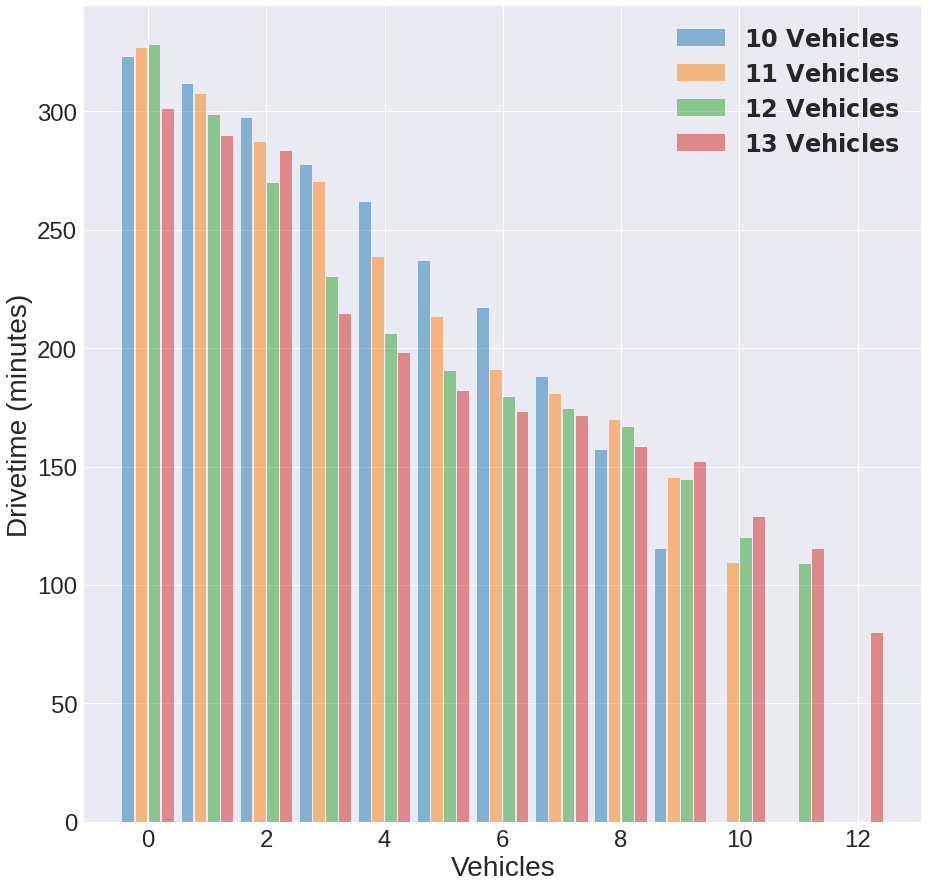

In [8]:
normal_df = pd.DataFrame(plot_data_IBEA)

normal_df["Parameter Group"] = 1

plot_vehicle_drivetimes(normal_df,1)

In [5]:
df = pd.DataFrame(plot_data_IBEA)

np.mean(np.array(df.fitness.to_list())[:,-1],axis=0)

array([336.97917981,  40.35121296,  53.77974279])

In [13]:
df.route_distance.apply(len).mean()

11.5

In [9]:
pd.DataFrame(plot_data_IBEA).to_csv("{}/IBEA_pick_and_drop_gini_third_objective_total_drivetime.csv".format(logpath))

In [54]:
from jmetal.algorithm.singleobjective import SimulatedAnnealing
from jmetal.operator.mutation import PermutationSwapMutation,ScrambleMutation,SimpleRandomMutation
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.util.comparator import DominanceComparator
from datetime import datetime

parameters_SA = optimal_parameters["SA"]

plot_data_SA = deepcopy(plot_data_storage_base)
for x in range(amount_of_runs):
    problem_SA = VRP_pickup_and_drop(data_model_input_single_objective)
    problem_SA.name = "SA"
    problem_SA.assignClosestEndPoint = True
    max_evaluations = amount_of_evaluations

    algorithm_SA = SimulatedAnnealing(problem=problem_SA,
                                   mutation=PermutationSwapMutation(parameters_SA["mutation"]),
                                   termination_criterion=StoppingByEvaluations(max_evaluations))

    performance_observer_SA = PerformanceObserver(max_iter=max_evaluations,frequency=observer_update_interval,params=[parameters_SA])
    performance_observer_SA.maxEpochs=  amount_of_runs
    performance_observer_SA.currentEpoch = x

    algorithm_SA.observable.register(observer=performance_observer_SA)
    algorithm_SA.run() 

    solutions_SA = algorithm_SA.get_result()        
    store_plot_data(plot_data_SA,performance_observer_SA,solutions_SA)




Epoch:30 of 30
Evaluations: 3000/3000
Params: {'mutation': 0.9}
IGD:853.940259647458
Best fitness: 342.3735                          
Best total fuel consumption:104.27 
Best total drive time:847.55                          
Computing time: 1.8s
Average computing speed: 1667.38it/s                          
Current Route:[['V0', 11, 9, 12, 25, 21, 20], ['V1', 16, 14, 8, 19, 5], ['V3', 24, 22], ['V2', 1, 3, 13, 2], ['V4', 23, 7, 17, 18, 4]]
Flags: []
Violation:0
Vehicle Amount:5


In [55]:
pd.DataFrame(plot_data_SA).to_csv("{}/SA_pick_and_drop.csv".format(logpath))

<ipython-input-31-2045cb6bb835>:4: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



(<AxesSubplot:>, <Figure size 1080x1080 with 1 Axes>)

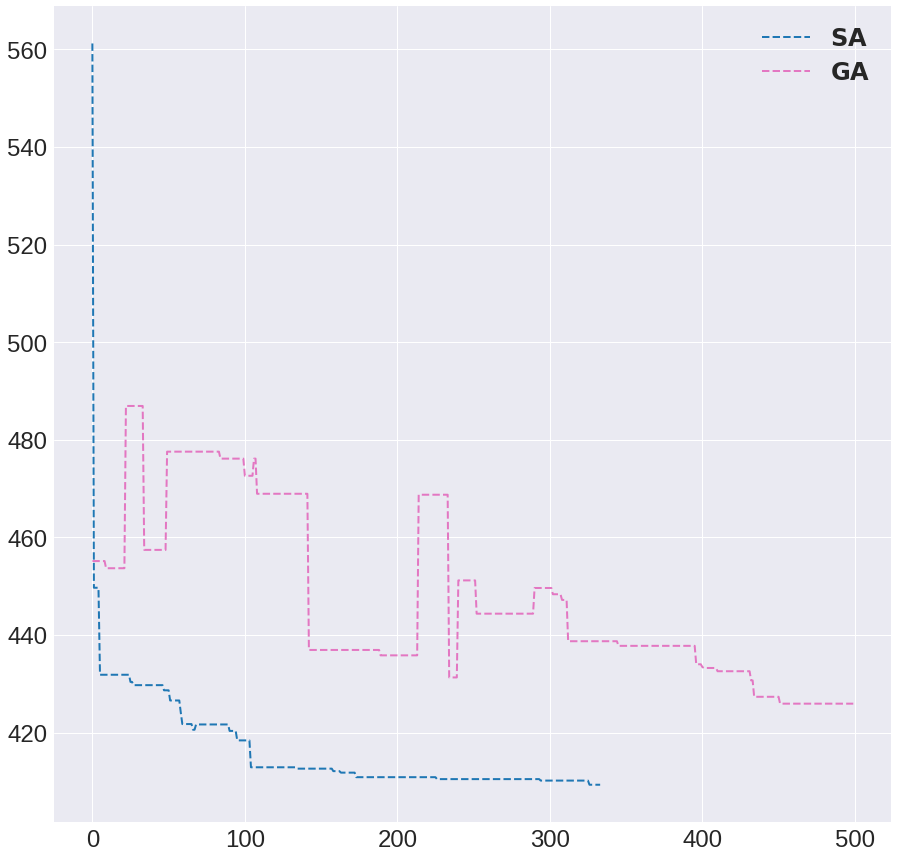

In [31]:
normal_method = np.mean(plot_data_GA["fuel_consumption"],axis=0)
pick_and_drop = np.mean(plot_data_NSGAIII_pick_and_drop["fuel_consumption"],axis=0)

curves = np.array([normal_method,pick_and_drop])
lables =["SA","GA"]




plot_conv_curves(curves,lables,show_domination_and_percentage_interval=False)

(<AxesSubplot:>, <Figure size 1080x1080 with 1 Axes>)

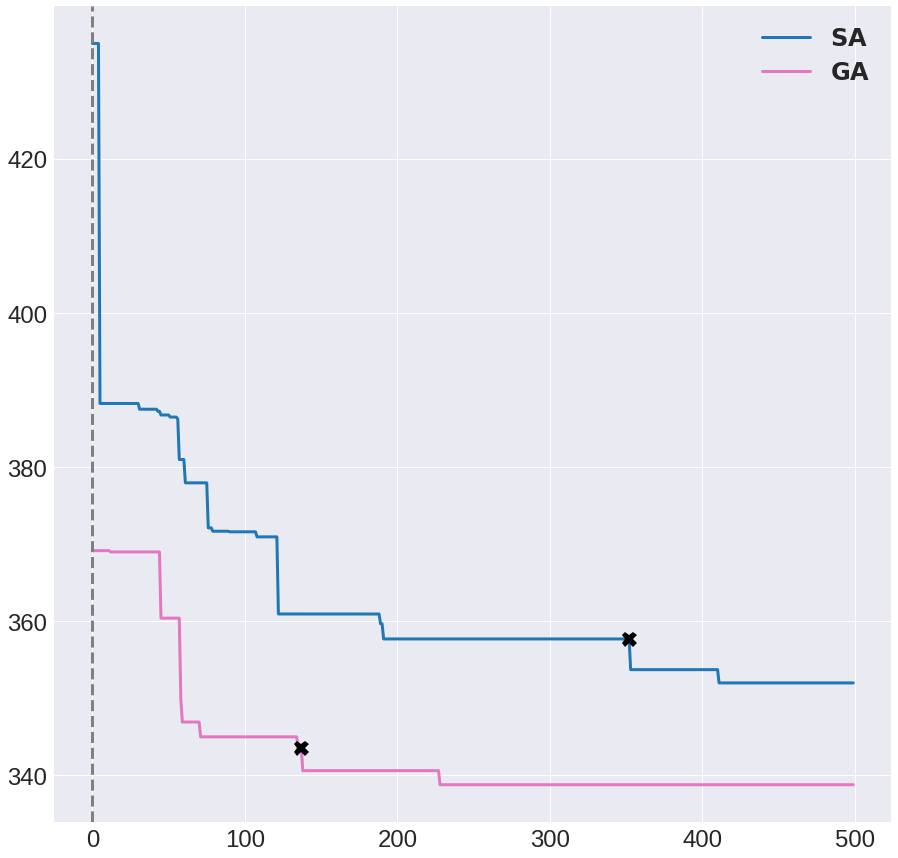

In [36]:
normal_method = np.mean(plot_data_NSGAIII["distance_to_origin"],axis=0)
pick_and_drop = np.mean(plot_data_NSGAIII_pick_and_drop["distance_to_origin"],axis=0)

curves = np.array([normal_method,pick_and_drop])
lables =["SA","GA"]




plot_conv_curves(curves,lables)

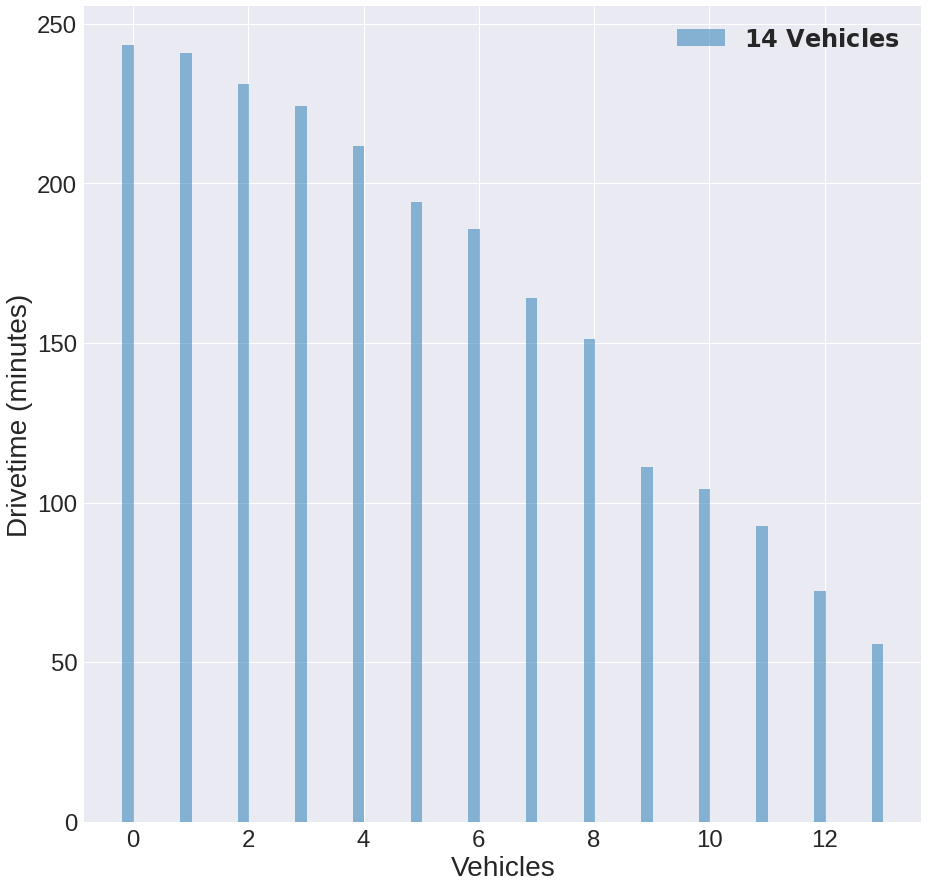

In [37]:
normal_df = pd.DataFrame(plot_data_NSGAIII)
normal_df["final_distance_to_origin"] =  [x[1]["distance_to_origin"][-1]for x in normal_df.iterrows()]
routes = normal_df.sort_values(by = "final_distance_to_origin").head(1).paths.to_list()[0]
normal_df["Parameter Group"] = 1
normal_best = normal_df.head(1)
plot_vehicle_drivetimes(normal_best,1)

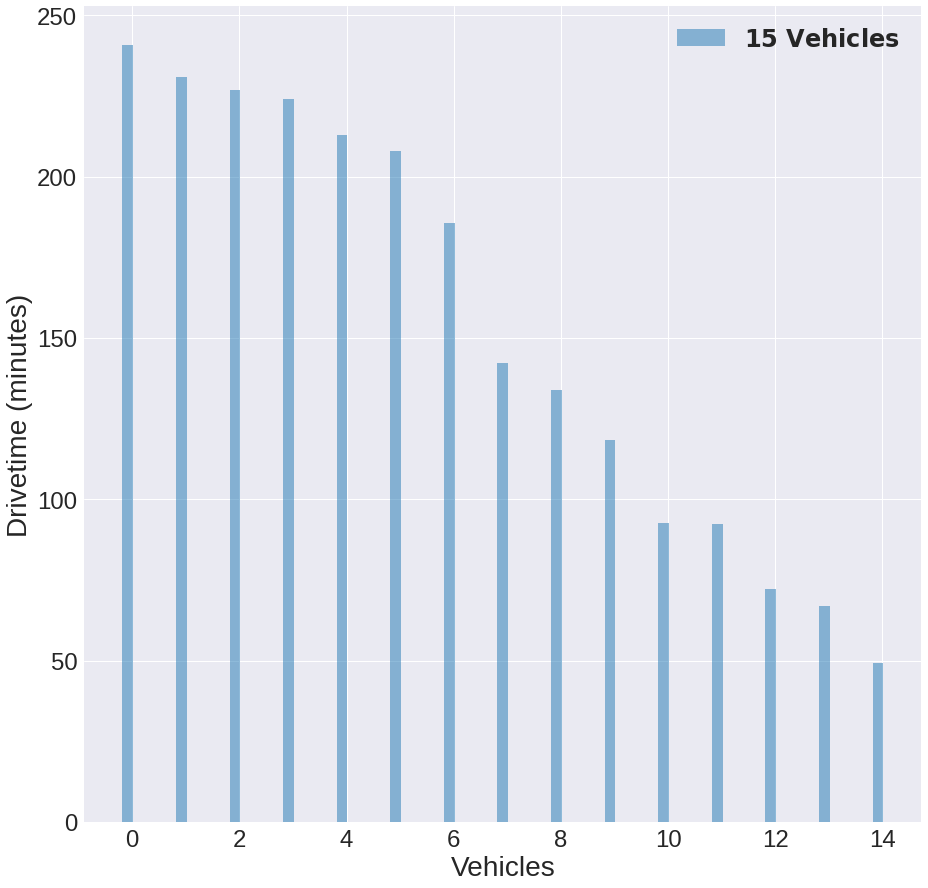

In [38]:
pick_and_drop_df = pd.DataFrame(plot_data_NSGAIII_pick_and_drop)
pick_and_drop_df["final_distance_to_origin"] =  [x[1]["distance_to_origin"][-1]for x in pick_and_drop_df.iterrows()]
routes = pick_and_drop_df.sort_values(by = "final_distance_to_origin").head(1).paths.to_list()[0]
pick_and_drop_df["Parameter Group"] = 1
pick_and_drop_best = pick_and_drop_df.head(1)
plot_vehicle_drivetimes(pick_and_drop_best,1)

In [32]:
import folium
from folium import Choropleth, Circle, Marker,PolyLine
from folium.plugins import HeatMap, MarkerCluster
folium_map = folium.Map(location=np.mean(points_coordinate,axis=0), tiles='openstreetmap', zoom_start=7,min_zoom=6)
colors = ["red", "blue", "green", "purple", "orange", "darkred", "cyan", "black"]
type_colors=["black","red","green"]
numerical_route = nsga3_numerical_path_normal
for routeNumber,route in enumerate(numerical_route):

    routes = []
    
    for stop in route:
        nodeType = 0
        if stop in startNodeIndeces:
            nodeType=2
        elif stop in endNodeIndeces:
            nodeType=1
        coordinates = (points_coordinate[stop][0],points_coordinate[stop][1])
        routes.append(coordinates)
        Marker(coordinates,icon=folium.Icon(color=type_colors[nodeType],icon_color='#FFFF00'),popup=customer_demands[stop]).add_to(folium_map)
      
    
    PolyLine(routes,color=colors[routeNumber%len(colors)]).add_to(folium_map)
    
        

folium_map


In [33]:
import folium
from folium import Choropleth, Circle, Marker,PolyLine
from folium.plugins import HeatMap, MarkerCluster
folium_map = folium.Map(location=np.mean(points_coordinate,axis=0), tiles='openstreetmap', zoom_start=7,min_zoom=6)
colors = ["red", "blue", "green", "purple", "orange", "darkred", "cyan", "black"]
type_colors=["black","red","green"]
numerical_route = nsga3_numerical_path_pick_and_drop
for routeNumber,route in enumerate(numerical_route):

    routes = []
    
    for stop in route:
        nodeType = 0
        if stop in startNodeIndeces:
            nodeType=2
        elif stop in endNodeIndeces:
            nodeType=1
        coordinates = (points_coordinate[stop][0],points_coordinate[stop][1])
        routes.append(coordinates)
        Marker(coordinates,icon=folium.Icon(color=type_colors[nodeType],icon_color='#FFFF00'),popup=customer_demands[stop]).add_to(folium_map)
      
    
    PolyLine(routes,color=colors[routeNumber%len(colors)]).add_to(folium_map)
    
        

folium_map
